# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [10]:
from cs231n.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
##print("dbg1",type(X_train),X_train.shape)
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength
import time
from cs231n.classifiers.linear_classifier import LinearSVM

#learning_rates = [0.7e-10,0.7e-9, 0.7e-8, 0.7e-7,0.7e-6,0.7e-5,0.7e-4]
#regularization_strengths = [2e2,2e3,2e4, 2e5, 2e6,2e7,2e8]

learning_rates = [0.2e-6,0.4e-6, 0.6e-6, 0.8e-6,1.2e-6,2.5e-6,4e-6]
regularization_strengths = [0.7e4,0.9e4,1.1e4, 1.5e4, 2e4,3.5e4,0.4e4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for l_rate in learning_rates:
  for r_strength in regularization_strengths:
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=l_rate, reg=r_strength,
                      num_iters=1500, verbose=True)
    toc = time.time()
    print('That took %fs' % (toc - tic))
    y_train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_acc)
    y_val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_acc)
    results[l_rate,r_strength] = [train_acc,val_acc]
    if val_acc>best_val:
      best_val = val_acc
      best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 21.216434
iteration 100 / 1500: loss 15.971157
iteration 200 / 1500: loss 12.990202
iteration 300 / 1500: loss 11.273001
iteration 400 / 1500: loss 10.294509
iteration 500 / 1500: loss 9.736445
iteration 600 / 1500: loss 9.418232
iteration 700 / 1500: loss 9.239213
iteration 800 / 1500: loss 9.135094
iteration 900 / 1500: loss 9.076439
iteration 1000 / 1500: loss 9.041502
iteration 1100 / 1500: loss 9.023243
iteration 1200 / 1500: loss 9.011325
iteration 1300 / 1500: loss 9.005629
iteration 1400 / 1500: loss 9.002326
That took 1.745241s
training accuracy: 0.369102
validation accuracy: 0.354000
iteration 0 / 1500: loss 24.523815
iteration 100 / 1500: loss 16.536609
iteration 200 / 1500: loss 12.668444
iteration 300 / 1500: loss 10.781991
iteration 400 / 1500: loss 9.865524
iteration 500 / 1500: loss 9.421486
iteration 600 / 1500: loss 9.203872
iteration 700 / 1500: loss 9.097433
iteration 800 / 1500: loss 9.046274
iteration 900 / 1500: loss 9.021251
iteration 10

iteration 400 / 1500: loss 9.560485
iteration 500 / 1500: loss 9.294425
iteration 600 / 1500: loss 9.154227
iteration 700 / 1500: loss 9.077844
iteration 800 / 1500: loss 9.038659
iteration 900 / 1500: loss 9.018674
iteration 1000 / 1500: loss 9.007971
iteration 1100 / 1500: loss 9.001477
iteration 1200 / 1500: loss 8.998823
iteration 1300 / 1500: loss 8.997477
iteration 1400 / 1500: loss 8.995481
That took 1.663182s
training accuracy: 0.416184
validation accuracy: 0.407000
iteration 0 / 1500: loss 21.496359
iteration 100 / 1500: loss 11.307294
iteration 200 / 1500: loss 9.424790
iteration 300 / 1500: loss 9.077248
iteration 400 / 1500: loss 9.011719
iteration 500 / 1500: loss 9.000156
iteration 600 / 1500: loss 8.998203
iteration 700 / 1500: loss 8.997512
iteration 800 / 1500: loss 8.997126
iteration 900 / 1500: loss 8.997043
iteration 1000 / 1500: loss 8.997651
iteration 1100 / 1500: loss 8.997723
iteration 1200 / 1500: loss 8.997148
iteration 1300 / 1500: loss 8.997877
iteration 140

iteration 700 / 1500: loss 8.999537
iteration 800 / 1500: loss 8.999404
iteration 900 / 1500: loss 8.999451
iteration 1000 / 1500: loss 8.999455
iteration 1100 / 1500: loss 8.999472
iteration 1200 / 1500: loss 8.999445
iteration 1300 / 1500: loss 8.999480
iteration 1400 / 1500: loss 8.999519
That took 1.656677s
training accuracy: 0.412796
validation accuracy: 0.414000
iteration 0 / 1500: loss 15.166152
iteration 100 / 1500: loss 10.701917
iteration 200 / 1500: loss 9.466811
iteration 300 / 1500: loss 9.128374
iteration 400 / 1500: loss 9.030484
iteration 500 / 1500: loss 9.004349
iteration 600 / 1500: loss 8.998242
iteration 700 / 1500: loss 8.996245
iteration 800 / 1500: loss 8.995813
iteration 900 / 1500: loss 8.995882
iteration 1000 / 1500: loss 8.995401
iteration 1100 / 1500: loss 8.994277
iteration 1200 / 1500: loss 8.995850
iteration 1300 / 1500: loss 8.995319
iteration 1400 / 1500: loss 8.995799
That took 1.651674s
training accuracy: 0.422612
validation accuracy: 0.424000
iterat

iteration 1100 / 1500: loss 8.999385
iteration 1200 / 1500: loss 8.999182
iteration 1300 / 1500: loss 8.999203
iteration 1400 / 1500: loss 8.999104
That took 1.645670s
training accuracy: 0.407224
validation accuracy: 0.402000
iteration 0 / 1500: loss 63.093994
iteration 100 / 1500: loss 8.999594
iteration 200 / 1500: loss 8.999585
iteration 300 / 1500: loss 8.999588
iteration 400 / 1500: loss 8.999489
iteration 500 / 1500: loss 8.999525
iteration 600 / 1500: loss 8.999526
iteration 700 / 1500: loss 8.999555
iteration 800 / 1500: loss 8.999492
iteration 900 / 1500: loss 8.999571
iteration 1000 / 1500: loss 8.999490
iteration 1100 / 1500: loss 8.999440
iteration 1200 / 1500: loss 8.999620
iteration 1300 / 1500: loss 8.999439
iteration 1400 / 1500: loss 8.999533
That took 1.642166s
training accuracy: 0.413408
validation accuracy: 0.418000
iteration 0 / 1500: loss 15.769337
iteration 100 / 1500: loss 9.112418
iteration 200 / 1500: loss 8.997086
iteration 300 / 1500: loss 8.994377
iteration

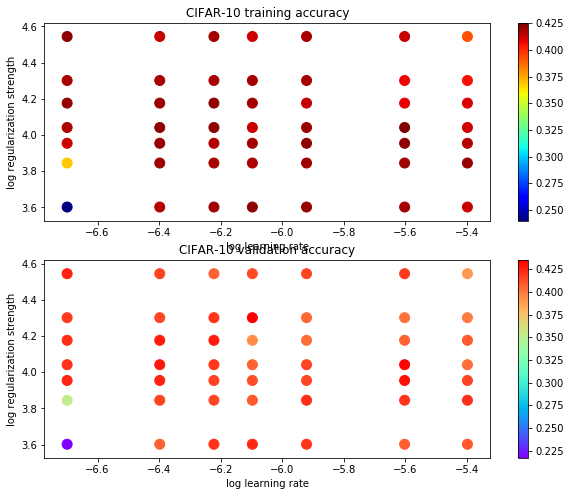

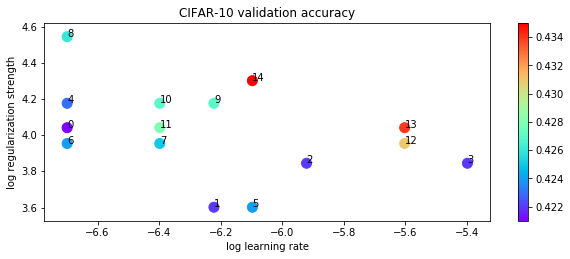

In [15]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap = "jet")
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
#print("dbg1: ", colors)
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap="rainbow")
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# plot validation accuracy of last few 
colors = [results[x][1] for x in results] # default size of markers is 20
indices = np.argsort(colors)[-15:]
x_scatter2 = np.array(x_scatter)[indices]
y_scatter2 = np.array(y_scatter)[indices]
colors2 = np.array(colors)[indices]

plt.subplot(2, 1, 2)
plt.scatter(x_scatter2, y_scatter2, marker_size, c=colors2,cmap = "rainbow")
plt.colorbar()

for i in range(15):
    plt.annotate(i, (x_scatter2[i], y_scatter2[i]))

plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.43


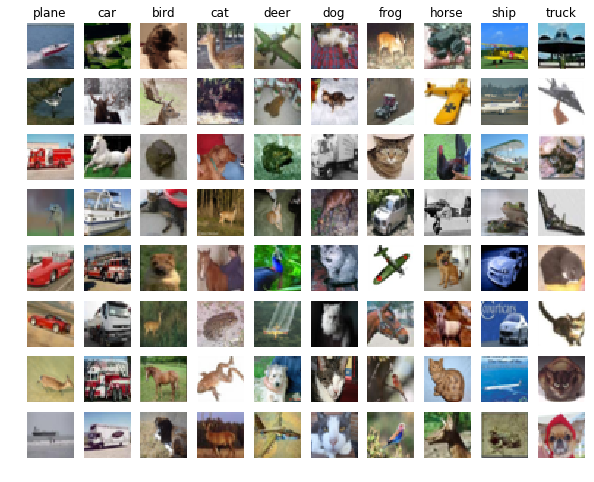

In [17]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Some of them do. Common misclassifications for planes for example are objects in front of a blue background such as a ship in water or a dog on a blue surface. Also cats are coomonly classified as dogs which makes sense as they probably share some similarities to dogs like eyes, fur, pointy ears.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [18]:
print(X_train_feats.shape)

(49000, 165)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
import time
learning_rates = [3.5e-1,5.5e-1,7.5e-1,1.25]
regularization_strengths = [5e-4,2e-3,6e-3,8e-4]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_new = None # The deepnet object that achieved the highest validation rate.


for l_rate in learning_rates:
  for r_strength in regularization_strengths:    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    tic = time.time()
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=l_rate, learning_rate_decay=0.95,
            reg=r_strength, verbose=True)
    toc = time.time()
    print('That took %fs' % (toc - tic))
    train_acc = stats["train_acc_history"][-1]
    print('training accuracy: %f' % train_acc)
    val_acc = stats["val_acc_history"][-1]
    print('validation accuracy: %f' % val_acc)    
    
    results[l_rate,r_strength] = [train_acc,val_acc]
    if val_acc>best_val:
      best_val = val_acc
      best_net = net

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.722138
iteration 200 / 10000: loss 1.372562
iteration 300 / 10000: loss 1.316753
iteration 400 / 10000: loss 1.225698
iteration 500 / 10000: loss 1.332744
iteration 600 / 10000: loss 1.195153
iteration 700 / 10000: loss 1.148994
iteration 800 / 10000: loss 1.132253
iteration 900 / 10000: loss 1.211016
iteration 1000 / 10000: loss 1.239287
iteration 1100 / 10000: loss 1.102042
iteration 1200 / 10000: loss 1.077934
iteration 1300 / 10000: loss 1.066914
iteration 1400 / 10000: loss 1.051001
iteration 1500 / 10000: loss 1.089293
iteration 1600 / 10000: loss 1.097852
iteration 1700 / 10000: loss 1.047582
iteration 1800 / 10000: loss 1.152561
iteration 1900 / 10000: loss 1.109080
iteration 2000 / 10000: loss 1.095303
iteration 2100 / 10000: loss 0.898777
iteration 2200 / 10000: loss 1.173130
iteration 2300 / 10000: loss 0.918585
iteration 2400 / 10000: loss 1.044592
iteration 2500 / 10000: loss 0.915401
iteration 2600 / 10000: 

iteration 1300 / 10000: loss 1.549664
iteration 1400 / 10000: loss 1.436639
iteration 1500 / 10000: loss 1.384973
iteration 1600 / 10000: loss 1.425788
iteration 1700 / 10000: loss 1.443364
iteration 1800 / 10000: loss 1.464604
iteration 1900 / 10000: loss 1.585568
iteration 2000 / 10000: loss 1.389476
iteration 2100 / 10000: loss 1.388114
iteration 2200 / 10000: loss 1.349219
iteration 2300 / 10000: loss 1.328487
iteration 2400 / 10000: loss 1.394368
iteration 2500 / 10000: loss 1.474538
iteration 2600 / 10000: loss 1.336866
iteration 2700 / 10000: loss 1.485305
iteration 2800 / 10000: loss 1.520150
iteration 2900 / 10000: loss 1.352876
iteration 3000 / 10000: loss 1.479626
iteration 3100 / 10000: loss 1.423644
iteration 3200 / 10000: loss 1.358881
iteration 3300 / 10000: loss 1.505310
iteration 3400 / 10000: loss 1.347815
iteration 3500 / 10000: loss 1.404196
iteration 3600 / 10000: loss 1.440083
iteration 3700 / 10000: loss 1.381944
iteration 3800 / 10000: loss 1.371420
iteration 39

iteration 2600 / 10000: loss 0.759743
iteration 2700 / 10000: loss 0.854586
iteration 2800 / 10000: loss 0.978098
iteration 2900 / 10000: loss 0.998792
iteration 3000 / 10000: loss 0.936937
iteration 3100 / 10000: loss 0.798169
iteration 3200 / 10000: loss 0.817978
iteration 3300 / 10000: loss 0.857258
iteration 3400 / 10000: loss 0.843357
iteration 3500 / 10000: loss 0.928479
iteration 3600 / 10000: loss 0.870113
iteration 3700 / 10000: loss 0.826071
iteration 3800 / 10000: loss 0.831820
iteration 3900 / 10000: loss 0.893408
iteration 4000 / 10000: loss 0.778850
iteration 4100 / 10000: loss 0.813494
iteration 4200 / 10000: loss 0.862318
iteration 4300 / 10000: loss 0.664595
iteration 4400 / 10000: loss 0.828148
iteration 4500 / 10000: loss 0.806913
iteration 4600 / 10000: loss 0.744767
iteration 4700 / 10000: loss 0.780789
iteration 4800 / 10000: loss 0.710472
iteration 4900 / 10000: loss 0.741504
iteration 5000 / 10000: loss 0.784060
iteration 5100 / 10000: loss 0.776601
iteration 52

iteration 3900 / 10000: loss 1.411346
iteration 4000 / 10000: loss 1.543731
iteration 4100 / 10000: loss 1.412937
iteration 4200 / 10000: loss 1.409244
iteration 4300 / 10000: loss 1.461780
iteration 4400 / 10000: loss 1.420351
iteration 4500 / 10000: loss 1.409947
iteration 4600 / 10000: loss 1.451168
iteration 4700 / 10000: loss 1.381133
iteration 4800 / 10000: loss 1.391208
iteration 4900 / 10000: loss 1.369411
iteration 5000 / 10000: loss 1.453430
iteration 5100 / 10000: loss 1.399082
iteration 5200 / 10000: loss 1.438256
iteration 5300 / 10000: loss 1.370454
iteration 5400 / 10000: loss 1.497688
iteration 5500 / 10000: loss 1.404436
iteration 5600 / 10000: loss 1.442689
iteration 5700 / 10000: loss 1.466879
iteration 5800 / 10000: loss 1.353737
iteration 5900 / 10000: loss 1.427943
iteration 6000 / 10000: loss 1.439621
iteration 6100 / 10000: loss 1.432517
iteration 6200 / 10000: loss 1.498655
iteration 6300 / 10000: loss 1.492638
iteration 6400 / 10000: loss 1.358506
iteration 65

iteration 5200 / 10000: loss 0.789353
iteration 5300 / 10000: loss 0.755836
iteration 5400 / 10000: loss 0.761683
iteration 5500 / 10000: loss 0.754460
iteration 5600 / 10000: loss 0.717841
iteration 5700 / 10000: loss 0.763407
iteration 5800 / 10000: loss 0.734166
iteration 5900 / 10000: loss 0.679077
iteration 6000 / 10000: loss 0.755661
iteration 6100 / 10000: loss 0.744910
iteration 6200 / 10000: loss 0.707663
iteration 6300 / 10000: loss 0.683349
iteration 6400 / 10000: loss 0.729130
iteration 6500 / 10000: loss 0.695812
iteration 6600 / 10000: loss 0.713432
iteration 6700 / 10000: loss 0.693737
iteration 6800 / 10000: loss 0.694692
iteration 6900 / 10000: loss 0.698819
iteration 7000 / 10000: loss 0.668281
iteration 7100 / 10000: loss 0.720133
iteration 7200 / 10000: loss 0.755483
iteration 7300 / 10000: loss 0.646740
iteration 7400 / 10000: loss 0.633060
iteration 7500 / 10000: loss 0.695004
iteration 7600 / 10000: loss 0.693933
iteration 7700 / 10000: loss 0.641747
iteration 78

iteration 6500 / 10000: loss 1.470064
iteration 6600 / 10000: loss 1.394996
iteration 6700 / 10000: loss 1.358888
iteration 6800 / 10000: loss 1.431325
iteration 6900 / 10000: loss 1.461648
iteration 7000 / 10000: loss 1.426091
iteration 7100 / 10000: loss 1.449102
iteration 7200 / 10000: loss 1.411785
iteration 7300 / 10000: loss 1.404807
iteration 7400 / 10000: loss 1.420215
iteration 7500 / 10000: loss 1.394238
iteration 7600 / 10000: loss 1.503435
iteration 7700 / 10000: loss 1.441505
iteration 7800 / 10000: loss 1.440326
iteration 7900 / 10000: loss 1.453949
iteration 8000 / 10000: loss 1.442092
iteration 8100 / 10000: loss 1.463904
iteration 8200 / 10000: loss 1.498792
iteration 8300 / 10000: loss 1.340324
iteration 8400 / 10000: loss 1.364658
iteration 8500 / 10000: loss 1.409732
iteration 8600 / 10000: loss 1.409402
iteration 8700 / 10000: loss 1.439149
iteration 8800 / 10000: loss 1.360963
iteration 8900 / 10000: loss 1.451749
iteration 9000 / 10000: loss 1.489534
iteration 91

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap = "brg")
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,cmap = "rainbow")
plt.colorbar()

#for i in range(len(results)):
#    plt.annotate(i, (x_scatter[i], y_scatter[i]))

plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# plot validation accuracy of last few 
colors = [results[x][1] for x in results] # default size of markers is 20
indices = np.argsort(colors)
x_scatter2 = np.array(x_scatter)[indices][-8:]
y_scatter2 = np.array(y_scatter)[indices][-8:]
colors2 = np.array(colors)[indices][-8:]

plt.subplot(2, 1, 2)
plt.scatter(x_scatter2, y_scatter2, marker_size, c=colors2,cmap = "rainbow")
plt.colorbar()

for i in range(8):
    plt.annotate(i, (x_scatter2[i], y_scatter2[i]))

plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()


In [24]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.481


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!